In [90]:
import csv
import glob
import json
import os

import nimfa
import numpy as np
np.set_printoptions(threshold=np.inf)
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn import preprocessing
import utils_jensen_shannon as ujs

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

In [91]:
pos_order = [
    "PROPN",
    "PUNCT",
    "DET",
    "ADJ",
    "NOUN",
    "ADV",
    "SPACE",
    "CONJ",
    "VERB",
    "PART",
    "ADP",
    "NUM",
    "PRON",
    "INTJ",
    "X",
    "SYM"
]

pos2color_dict = {
    "PROPN": "#ff8cc0",
    "PUNCT": "#ffa8b2",
    "DET": "#ff4298",
    "ADJ": "#7c88ff",
    "NOUN": "#74ff6e",
    "ADV": "#ffbcf8",
    "SPACE": "#ff86d4",
    "CONJ": "#0cffb4",
    "VERB": "#fff0dc",
    "PART": "#2cf0ff",
    "ADP": "#ff6e4c",
    "NUM": "#3c54ff",
    "PRON": "#ffaa44",
    "INTJ": "#ff4e8c",
    "X": "#5cff58",
    "SYM": "#54ff18"
}

poems_folder = "/Users/PeregrinePickle/Documents/Programming/twic/data/dickinson/input/txt/"
class_folder = "/Users/PeregrinePickle/Documents/School/New York University/Seminars/Reading and Writing Archives/"
pos_files_folder = "Writings/Final Project/pos_files/"
gm_output_folder = "/Users/PeregrinePickle/Documents/School/Columbia University/Seminars/Foundations of Graphical Models/Writings/Final Project/"
nf_folder = "Writings/Final Project/New Fascicles Files/Code/"
pos_filename = "fascicle{0}_pos_counts.json"

fascicle_count = 40
fascicle_pos_json = []
fascicle_overall_pos = []
poem_count = 0
pid_to_mx_entry = {}
pid_to_title = {}
poem_titles = []
poem_fileid_to_info = {}
poem_procorder_to_fileid = {}

In [92]:
def load_fascicle_pos_json():

    global poem_count

    poem_order = 0
    for index in range(fascicle_count):

        # Create an aggregate pos dict for each fascicle
        fascicle_overall_dict = {}
        for pos in pos_order:
            fascicle_overall_dict[pos] = 0

        # Read the previously calculated pos counts for each fascicle poem
        with open(class_folder + pos_files_folder + pos_filename.format(str(index + 1)), "rU") as json_file:    
            data = json.load(json_file)
            fascicle_pos_json.append(data)

            # Additional counting work
            for index2 in range(len(fascicle_pos_json[index])):

                # Keep track of how many poems are in all fascicles
                poem_count += 1
                
                # Save the poem title
                poem_titles.append(fascicle_pos_json[index][index2]["title"])
                
                # Save poem info
                file_id = fascicle_pos_json[index][index2]["file_id"]
                poem_fileid_to_info[file_id] = {}
                poem_fileid_to_info[file_id]["title"] = fascicle_pos_json[index][index2]["title"]
                poem_fileid_to_info[file_id]["order_id"] = index2                
                poem_fileid_to_info[file_id]["fascicle_id"] = index
                
                # Save processing order
                poem_procorder_to_fileid[str(poem_order)] = file_id

                # Go through each part of speech
                for pos in pos_order:

                    # Fill out any missing pos keys
                    if pos not in fascicle_pos_json[index][index2]["counts"]:
                        fascicle_pos_json[index][index2]["counts"][pos] = 0

                    # Add to aggregate fascicle pos counts
                    fascicle_overall_dict[pos] += fascicle_pos_json[index][index2]["counts"][pos]
                
                poem_order += 1

        # Fascicle pos counts are averaged over the # of poems in each book
        for pos in pos_order:
            fascicle_overall_dict[pos] /= float(len(fascicle_pos_json[index]))
        
        # Save the overall average fascicle pos counts
        fascicle_overall_pos.append(fascicle_overall_dict)
        
def build_data_matrix():

    global poem_count, fascicle_count

    # A zeroed data matrix NxN where N = # of poems + # of fascicles
    data_matrix = np.zeros((poem_count, len(pos_order)))

    # Each row of the matrix represents a poem or overall fascicle, each column a POS category
    # NOTE: Matrix values represent Jensen-Shannon distance between distributions of pos relative frequencies
    #       with respect to each individual poem/fascicle
    current_row = 0
    for index in range(fascicle_count):

        # Save poem pos counts for the fascicle to the matrix
        for index2 in range(len(fascicle_pos_json[index])):
            pid_to_mx_entry["{0}, {1}".format(index, index2)] = current_row
            for index3 in range(len(pos_order)):
                pos = pos_order[index3]
                data_matrix[current_row, index3] = fascicle_pos_json[index][index2]["counts"][pos]

            # Increment to the next row for the next poem/fascicle entry
            current_row += 1                
            
    # Relativize all POS matrix entries to account for poem length for each poem
    for row_index in range(poem_count):
        entry_sum = 0
        for entry in data_matrix[row_index]:
            entry_sum += entry
        if entry_sum > 0:
            for column_index in range(len(pos_order)):
                data_matrix[row_index, column_index] /= float(entry_sum) 

    # Return the data matrix
    return data_matrix


def preprocess_checks_and_tasks(p_data_matrix):

    # Check level of sparsity
    print("Sparsity: {0}".format(np.sum(0 != p_data_matrix ) / float(p_data_matrix.size)))

    # Check for negative elements
    print("# Negative Entries: {0}".format(np.sum(p_data_matrix < 0)))

    # Redundant safety to remove negative elements (for non-negative matrix factorization)
    for index in range(len(p_data_matrix)):
        for index2 in range(len(p_data_matrix[index])):
            if p_data_matrix[index, index2] < 0:
                # print "Zeroed matrix entry: {0}, {1}".format(index, index2)
                p_data_matrix[index, index2] = 0

    # Normalize rows in the matrix
    p_data_matrix = preprocessing.Normalizer().fit_transform(p_data_matrix)    


def probabilistic_nmf(p_data_matrix, p_factorization_rank):

    pmf_args = {
        "data_matrix": p_data_matrix,
        "rank": p_factorization_rank,
        "seed": "random_vcol",
        "max_iter": 10,
        "n_run": 10,
        "rel_error": 1e-5
    }

    pmf = nimfa.Pmf(pmf_args["data_matrix"].T, rank=pmf_args["rank"], seed=pmf_args["seed"], 
                    max_iter=pmf_args["max_iter"], n_run=pmf_args["n_run"], rel_error=pmf_args["rel_error"],
                    track_factor=True)

    return pmf

In [93]:
# Load all POS counts for all fascicles and their poems
load_fascicle_pos_json()

# Build data matrix NxN where N = # of poems + # of fascicles
# NOTE: Matrix values represent Jensen-Shannon distance between distributions of pos relative frequencies
#       with respect to each individual poem/fascicle
data_matrix = build_data_matrix()

# Perform any preprocess checking and transformations before matrix factorization
preprocess_checks_and_tasks(data_matrix)

# Perform non-negative matrix factorization to cluster by poem/fascicle in R^(r_k)
# where r_k is the factorization rank whose optimal value is to be determined by another study
r_k = 2
fascicle_pmf = probabilistic_nmf(data_matrix, r_k)

pmf_fit = fascicle_pmf()
pmf_fit_summary = pmf_fit.summary()

# PMF Value Test Prints
print "Fit Summary Keys: \n{0}".format(pmf_fit.summary().keys())

Sparsity: 0.593942189422
# Negative Entries: 0
Fit Summary Keys: 
['select_features', 'cophenetic', 'euclidean', 'evar', 'n_iter', 'rank', 'kl', 'dispersion', 'connectivity', 'sparseness', 'residuals', 'score_features', 'predict_samples', 'consensus', 'predict_features', 'n_run', 'rss']


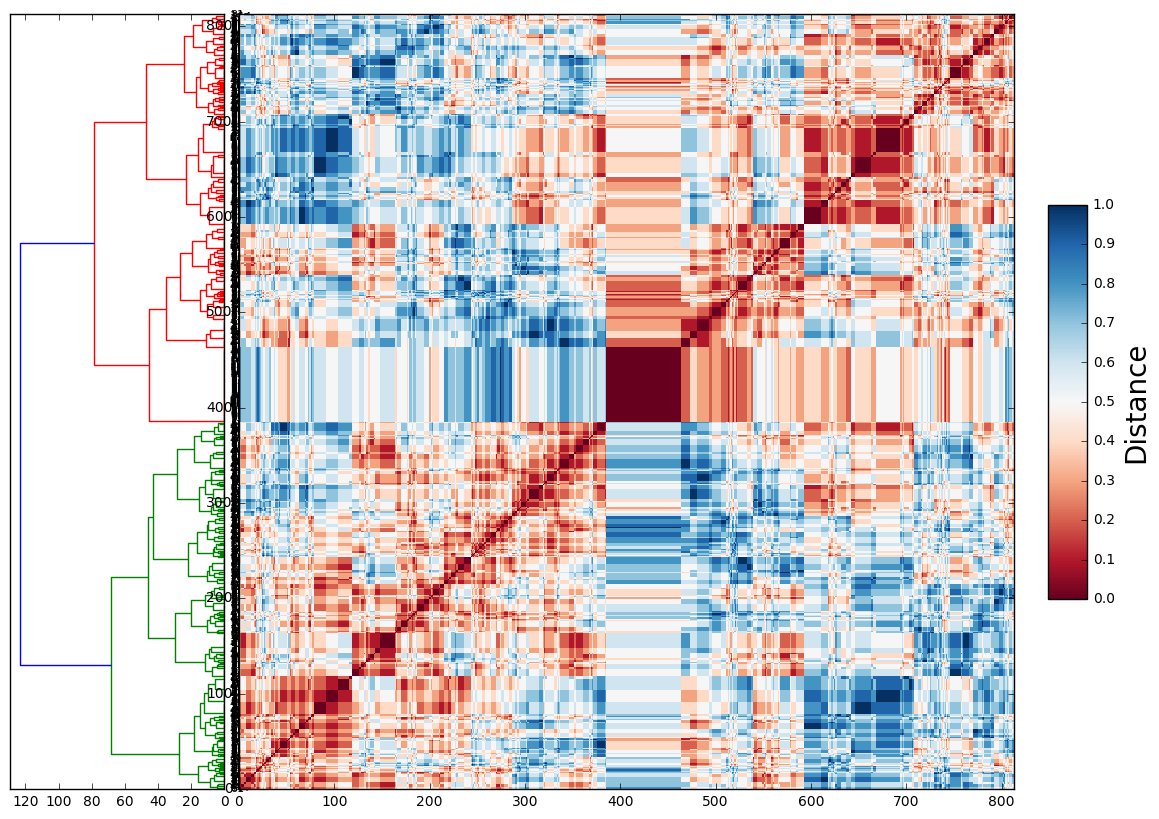

In [94]:
def clean_axis(ax):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)

fig = plt.figure(figsize=(13.9, 10))
heatmapGS = gridspec.GridSpec(1, 2, wspace=.01, hspace=0., width_ratios=[0.25,1])

C = 1 - pmf_fit.fit.consensus()
Y = sch.linkage(C, method='ward')

denAX = fig.add_subplot(heatmapGS[0,0])
# denD = sch.dendrogram(Y, orientation='left', link_color_func=lambda k: 'black', labels=poem_titles)
denD = sch.dendrogram(Y, orientation='left', labels=range(len(poem_titles)), leaf_font_size=8.)
# clean_axis(denAX)

heatmapAX = fig.add_subplot(heatmapGS[0,1])
D = C[denD['leaves'], :][:, denD['leaves']]
axi = heatmapAX.imshow(D, interpolation='nearest', aspect='equal', origin='lower', cmap='RdBu') 
# clean_axis(heatmapAX)

cb = fig.colorbar(axi, fraction=0.046, pad=0.04, aspect=10) 
cb.set_label('Distance', fontsize=20)

In [95]:
max_d = len(poem_titles)
clusters = fcluster(Y, max_d, criterion='maxclust')
print len(clusters)

813


In [96]:
print(max(clusters))

247


In [97]:
print(min(clusters))

1


In [98]:
poems_by_cluster = {}

for index in range(len(clusters)):
    cluster_name = str(clusters[index])
    if cluster_name not in poems_by_cluster:
        poems_by_cluster[cluster_name] = []
    poems_by_cluster[cluster_name].append(index)
    
count = 0
for key in poems_by_cluster:
    count += len(poems_by_cluster[key])
print count



813


In [99]:
output_count = 0

with open(gm_output_folder + "poems_by_pmfcluster.csv", "w") as output_file:
    
    output_file.write("cluster_id,file_id,fascicle_no,order_no,title\n")
    
    for cluster_id in poems_by_cluster:
        for poem_id in poems_by_cluster[cluster_id]:            
            file_id = poem_procorder_to_fileid[str(poem_id)]
            output_count += 1
            output_file.write("{0},{1},{2},{3},\"{4}\"\n".format(cluster_id, file_id,
                                                            poem_fileid_to_info[str(file_id)]["fascicle_id"],
                                                            poem_fileid_to_info[str(file_id)]["order_id"],
                                                            poem_fileid_to_info[str(file_id)]["title"]))
            
print output_count
    

813


In [100]:
print fascicle_pmf.select_features()

[ True False  True False False False False False False False False False
  True False False False]


In [101]:
x = fascicle_pmf.coef()
print x.shape
# with open("/Users/PeregrinePickle/Desktop/output.txt", "w") as output_file:
#     x = fascicle_pmf.coef()

(2, 813)
